In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
import torch.utils.data as Data
import torchvision.datasets 
import torchvision.transforms
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
# global variable
VECTOR_SIZE = 10

### Data preprocess

In [3]:
df_accepted = pd.read_excel('ICLR_accepted.xlsx')
df_rejected = pd.read_excel('ICLR_rejected.xlsx')

df_accepted.columns = ['title']
df_rejected.columns = ['title']
df_accepted['label'] = 1
df_rejected['label'] = 0

df_all = pd.concat([df_accepted, df_rejected], axis=0)

In [4]:
display(df_accepted.loc[:49].head())
display(df_rejected.loc[:49].head())

,title,label
0,Minimal-Entropy Correlation Alignment for Unsu...,1
1,Large Scale Optimal Transport and Mapping Esti...,1
2,TRUNCATED HORIZON POLICY SEARCH: COMBINING REI...,1
3,Model-Ensemble Trust-Region Policy Optimization,1
4,A Neural Representation of Sketch Drawings,1


,title,label
0,Hierarchical Adversarially Learned Inference,0
1,Learning to Compute Word Embeddings On the Fly,0
2,Graph2Seq: Scalable Learning Dynamics for Graphs,0
3,Generating Differentially Private Datasets Usi...,0
4,Representing dynamically: An active process fo...,0


In [5]:
# split train & test dataframe
df_train_X = pd.DataFrame(pd.concat([df_accepted.loc[50:, 'title'], df_rejected.loc[50:, 'title']], axis=0).reset_index(drop=True))
df_test_X = pd.DataFrame(pd.concat([df_accepted.loc[:49, 'title'], df_rejected.loc[:49, 'title']], axis=0).reset_index(drop=True))

df_train_y = pd.concat([df_accepted.loc[50:, 'label'], df_rejected.loc[50:, 'label']], axis=0).reset_index(drop=True)
df_test_y = pd.concat([df_accepted.loc[:49, 'label'], df_rejected.loc[:49, 'label']], axis=0).reset_index(drop=True)

In [6]:
# create ingore word list, which is reference from NLTK
ignore_word_list = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves',
                           'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs',
                           'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were',
                           'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if',
                           'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through',
                           'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',
                           'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some',
                           'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now', 'd', 'll',
                           'm', 'o', 're', 've', 'y', 'ain', 'aren', 'couldn', 'didn', 'doesn', 'hadn', 'hasn', 'haven', 'isn', 'ma', 'mightn', 'mustn', 'needn', 'shan',
                           'shouldn', 'wasn', 'weren', 'won', 'wouldn', '!', ',', '.', '?', '-s', '-ly', '</s>', 's', '&', '']

In [7]:
def create_word_dict(df):
    word_dict = []
    for idx, row in df.iterrows():
        word_list = row['title'].split(' ')
        for word in word_list:

            word = word.strip('s: ').lower()
            if word not in ignore_word_list and word not in word_dict:
                    word_dict.append(word)
    print('collect number of word: ', len(word_dict))
    
    word_dict = dict(zip(word_dict, range(1, len(word_dict)+1)))
    return word_dict

In [8]:
# create word dict
word_dict = create_word_dict(df_all)
print(word_dict)

collect number of word:  2273
{'minimal-entropy': 1, 'correlation': 2, 'alignment': 3, 'unsupervised': 4, 'deep': 5, 'domain': 6, 'adaptation': 7, 'large': 8, 'scale': 9, 'optimal': 10, 'transport': 11, 'mapping': 12, 'estimation': 13, 'truncated': 14, 'horizon': 15, 'policy': 16, 'search': 17, 'combining': 18, 'reinforcement': 19, 'learning': 20, 'imitation': 21, 'model-ensemble': 22, 'trust-region': 23, 'optimization': 24, 'neural': 25, 'representation': 26, 'sketch': 27, 'drawing': 28, 'logged': 29, 'bandit': 30, 'feedback': 31, 'latent': 32, 'permutation': 33, 'gumbel-sinkhorn': 34, 'network': 35, 'embedding': 36, 'space': 37, 'transferable': 38, 'robot': 39, 'skill': 40, 'goal': 41, 'intrinsically': 42, 'motivated': 43, 'exploration': 44, 'multi-view': 45, 'data': 46, 'generation': 47, 'without': 48, 'view': 49, 'supervision': 50, 'bayesian': 51, 'showdown': 52, 'empirical': 53, 'comparison': 54, 'thompson': 55, 'sampling': 56, 'semantic': 57, 'interpolation': 58, 'implicit': 59, 

In [9]:
def convert_sentence_to_vector(df, word_dict):
    sentence_vector = []
    for idx, row in df.iterrows():
        temp_vector = []
        word_list = row['title']
        count = 0
        for word in word_list.split(' '):
            temp_vector.append(word_dict.get(word.lower(), 0))
            # print(word, count, temp_vector)
            count += 1
            if(count == 10):
                break
        while(count < 10):
            temp_vector.append(0)
            count += 1

        # print(row['title'])
        # print(temp_vector)
        sentence_vector.append(temp_vector)

    sentence_vector = np.array(sentence_vector)
    return sentence_vector

In [10]:
# convert sentence to vector
train_X = convert_sentence_to_vector(df_train_X, word_dict)
test_X = convert_sentence_to_vector(df_test_X, word_dict)

train_X = torch.from_numpy(train_X)
test_X = torch.from_numpy(test_X)
train_y = torch.from_numpy(df_train_y.values)
test_y = torch.from_numpy(df_test_y.values)

train_X = train_X.view(-1, 1, 10).type(torch.FloatTensor)
test_X = test_X.view(-1, 1, 10).type(torch.FloatTensor)
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

torch.Size([1235, 1, 10]) torch.Size([1235]) torch.Size([100, 1, 10]) torch.Size([100])


In [11]:
train_dataset = Data.TensorDataset(train_X, train_y)
test_dataset = Data.TensorDataset(test_X, test_y)

train_loader = Data.DataLoader(
    dataset = train_dataset,      # torch TensorDataset format
    batch_size = 128,      # mini batch size
    shuffle = True,               # 要不要打乱数据 (打乱比较好)
    num_workers=4,              # 多线程来读数据
)

test_loader = Data.DataLoader(
    dataset = test_dataset,      # torch TensorDataset format
    batch_size = 10,      # mini batch size
    shuffle = False,
    num_workers=4,              # 多线程来读数据
)

### RNN

In [12]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(input_size=10, hidden_size=512, num_layers=1)
        self.out = nn.Linear(in_features=512, out_features=2)
        
    def forward(self, x):
        # x: (batch_size, time_step, input_size)
        # h_state: (num_layers, batch_size, hidden_size)
        # r_out: (batch_size, time_step, hidden_size)
        r_out, h_state = self.rnn(x, None)
        outs = self.out(r_out.squeeze(0))
        return outs.squeeze(1)

### LSTM

In [13]:
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        
        self.lstm = nn.LSTM(input_size=10, hidden_size=512, num_layers=1)
        self.output = nn.Linear(in_features=512, out_features=2)
    
    def forward(self, x):
        r_out, (r_h, r_c) = self.lstm(x, None)
        out = self.output(r_out[:, -1, :])
        return out

In [14]:
class module():
    def __init__(self, net, train_loader, test_loader, EPOCH=20, LR=0.0001):
        self.net = net
        self.optimizer = torch.optim.Adam(net.parameters(), lr = LR)
        self.criterion = nn.CrossEntropyLoss()
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.EPOCH_ = EPOCH
        self.LR_ = LR

        self.net = self.net.to(device)
        if device == 'cuda':
            # self.net = torch.nn.DataParallel(self.net)
            torch.backends.cudnn.benchmark = True

    def start(self):

        history_loss = []
        history_train_acc = []
        history_test_acc = []
        for epoch in range(self.EPOCH_):
            print('Epoch:', epoch)
            train_loss, train_acc = self.train()
            test_loss, test_acc = self.test()

            history_loss.append(train_loss)
            history_train_acc.append(train_acc)
            history_test_acc.append(test_acc)
        return history_loss, history_train_acc, history_test_acc

    def train(self):
        self.net.train()
        train_loss = 0
        correct = 0
        total = 0
        for step, (batch_X, batch_y) in enumerate(self.train_loader):
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            self.optimizer.zero_grad()
            outputs = self.net(batch_X)
            
            loss = self.criterion(outputs, batch_y)
            loss.backward()
            self.optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += batch_y.size(0)
            correct += predicted.eq(batch_y).sum().item()        

        print('【Training】Loss: %.3f | Acc: %.3f%% (%d/%d)' % ( train_loss, 100.*(correct/total), correct, total ))
        return train_loss, (correct/total)

    def test(self):
        self.net.eval()

        test_loss = 0
        correct = 0
        total = 0
        with torch.no_grad(): 
            for step, (batch_X, batch_y) in enumerate(self.test_loader):
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = self.net(batch_X)
                loss = self.criterion(outputs, batch_y)

                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += batch_y.size(0)
                correct += predicted.eq(batch_y).sum().item()   

        print('【Testing】Loss: %.3f | Acc: %.3f%% (%d/%d)' % ( test_loss, 100.*(correct/total), correct, total ))
        return test_loss, (correct/total)

#### RNN結果

In [15]:
rnn_module = module(RNN(), train_loader, test_loader, EPOCH=100, LR=0.0005)
history_loss, history_train_acc, history_test_acc = rnn_module.start()

Epoch: 0
【Training】Loss: 7.087 | Acc: 55.142% (681/1235)
【Testing】Loss: 6.727 | Acc: 62.000% (62/100)
Epoch: 1
【Training】Loss: 6.321 | Acc: 65.020% (803/1235)
【Testing】Loss: 6.390 | Acc: 59.000% (59/100)
Epoch: 2
【Training】Loss: 5.905 | Acc: 71.255% (880/1235)
【Testing】Loss: 6.352 | Acc: 64.000% (64/100)
Epoch: 3
【Training】Loss: 5.762 | Acc: 70.526% (871/1235)
【Testing】Loss: 6.246 | Acc: 62.000% (62/100)
Epoch: 4
【Training】Loss: 5.554 | Acc: 77.571% (958/1235)
【Testing】Loss: 6.190 | Acc: 65.000% (65/100)
Epoch: 5
【Training】Loss: 5.362 | Acc: 76.842% (949/1235)
【Testing】Loss: 6.010 | Acc: 66.000% (66/100)
Epoch: 6
【Training】Loss: 5.187 | Acc: 80.081% (989/1235)
【Testing】Loss: 6.040 | Acc: 66.000% (66/100)
Epoch: 7
【Training】Loss: 5.022 | Acc: 82.753% (1022/1235)
【Testing】Loss: 6.023 | Acc: 65.000% (65/100)
Epoch: 8
【Training】Loss: 4.912 | Acc: 83.563% (1032/1235)
【Testing】Loss: 6.033 | Acc: 66.000% (66/100)
Epoch: 9
【Training】Loss: 4.761 | Acc: 83.887% (1036/1235)
【Testing】Loss: 6.174 |

【Training】Loss: 1.358 | Acc: 97.895% (1209/1235)
【Testing】Loss: 7.659 | Acc: 65.000% (65/100)
Epoch: 80
【Training】Loss: 1.361 | Acc: 98.057% (1211/1235)
【Testing】Loss: 7.295 | Acc: 67.000% (67/100)
Epoch: 81
【Training】Loss: 1.270 | Acc: 98.219% (1213/1235)
【Testing】Loss: 7.544 | Acc: 69.000% (69/100)
Epoch: 82
【Training】Loss: 1.318 | Acc: 97.571% (1205/1235)
【Testing】Loss: 7.323 | Acc: 69.000% (69/100)
Epoch: 83
【Training】Loss: 1.358 | Acc: 97.895% (1209/1235)
【Testing】Loss: 7.515 | Acc: 69.000% (69/100)
Epoch: 84
【Training】Loss: 1.224 | Acc: 97.976% (1210/1235)
【Testing】Loss: 6.676 | Acc: 72.000% (72/100)
Epoch: 85
【Training】Loss: 1.274 | Acc: 97.733% (1207/1235)
【Testing】Loss: 6.852 | Acc: 69.000% (69/100)
Epoch: 86
【Training】Loss: 1.202 | Acc: 98.300% (1214/1235)
【Testing】Loss: 6.384 | Acc: 69.000% (69/100)
Epoch: 87
【Training】Loss: 1.273 | Acc: 97.733% (1207/1235)
【Testing】Loss: 7.057 | Acc: 71.000% (71/100)
Epoch: 88
【Training】Loss: 1.163 | Acc: 97.895% (1209/1235)
【Testing】Loss: 

In [16]:
print('total number of parameters:', sum(p.numel() for p in rnn_module.net.parameters()))

total number of parameters: 269314


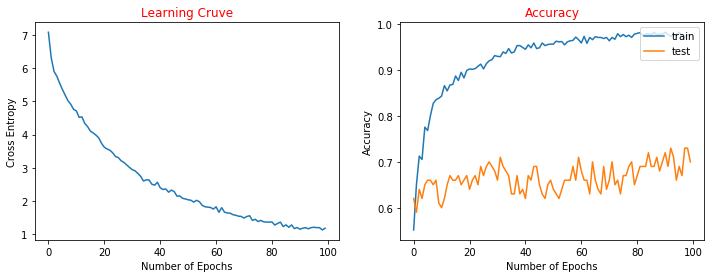

In [17]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 4)
ax[0].set_title('Learning Cruve', color='r')
ax[0].set_xlabel('Number of Epochs')
ax[0].set_ylabel('Cross Entropy')
ax[0].plot(history_loss)

ax[1].set_title('Accuracy', color='r')
ax[1].set_xlabel('Number of Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].plot(history_train_acc, label = 'train')
ax[1].plot(history_test_acc, label = 'test')
plt.legend(loc=1)

#### LSTM結果

In [18]:
lstm_module = module(LSTM(), train_loader, test_loader, EPOCH=100, LR=0.0005)
history_loss, history_train_acc, history_test_acc = lstm_module.start()

Epoch: 0
【Training】Loss: 6.953 | Acc: 53.522% (661/1235)
【Testing】Loss: 6.890 | Acc: 51.000% (51/100)
Epoch: 1
【Training】Loss: 6.462 | Acc: 63.239% (781/1235)
【Testing】Loss: 6.794 | Acc: 56.000% (56/100)
Epoch: 2
【Training】Loss: 6.296 | Acc: 67.449% (833/1235)
【Testing】Loss: 6.772 | Acc: 56.000% (56/100)
Epoch: 3
【Training】Loss: 6.004 | Acc: 73.360% (906/1235)
【Testing】Loss: 6.621 | Acc: 62.000% (62/100)
Epoch: 4
【Training】Loss: 5.860 | Acc: 73.765% (911/1235)
【Testing】Loss: 6.622 | Acc: 63.000% (63/100)
Epoch: 5
【Training】Loss: 5.735 | Acc: 75.142% (928/1235)
【Testing】Loss: 6.548 | Acc: 62.000% (62/100)
Epoch: 6
【Training】Loss: 5.510 | Acc: 77.490% (957/1235)
【Testing】Loss: 6.485 | Acc: 60.000% (60/100)
Epoch: 7
【Training】Loss: 5.376 | Acc: 78.785% (973/1235)
【Testing】Loss: 6.434 | Acc: 62.000% (62/100)
Epoch: 8
【Training】Loss: 5.242 | Acc: 79.595% (983/1235)
【Testing】Loss: 6.378 | Acc: 62.000% (62/100)
Epoch: 9
【Training】Loss: 5.107 | Acc: 81.457% (1006/1235)
【Testing】Loss: 6.194 | A

【Training】Loss: 1.231 | Acc: 97.409% (1203/1235)
【Testing】Loss: 6.673 | Acc: 71.000% (71/100)
Epoch: 80
【Training】Loss: 1.237 | Acc: 97.490% (1204/1235)
【Testing】Loss: 6.362 | Acc: 72.000% (72/100)
Epoch: 81
【Training】Loss: 1.250 | Acc: 96.923% (1197/1235)
【Testing】Loss: 6.493 | Acc: 72.000% (72/100)
Epoch: 82
【Training】Loss: 1.150 | Acc: 97.733% (1207/1235)
【Testing】Loss: 6.238 | Acc: 73.000% (73/100)
Epoch: 83
【Training】Loss: 1.184 | Acc: 97.247% (1201/1235)
【Testing】Loss: 6.261 | Acc: 73.000% (73/100)
Epoch: 84
【Training】Loss: 1.175 | Acc: 97.895% (1209/1235)
【Testing】Loss: 6.301 | Acc: 73.000% (73/100)
Epoch: 85
【Training】Loss: 1.132 | Acc: 97.733% (1207/1235)
【Testing】Loss: 6.249 | Acc: 75.000% (75/100)
Epoch: 86
【Training】Loss: 1.066 | Acc: 97.652% (1206/1235)
【Testing】Loss: 6.830 | Acc: 72.000% (72/100)
Epoch: 87
【Training】Loss: 1.072 | Acc: 98.057% (1211/1235)
【Testing】Loss: 6.553 | Acc: 72.000% (72/100)
Epoch: 88
【Training】Loss: 1.071 | Acc: 98.138% (1212/1235)
【Testing】Loss: 

In [19]:
print('total number of parameters:', sum(p.numel() for p in lstm_module.net.parameters()))

total number of parameters: 1074178


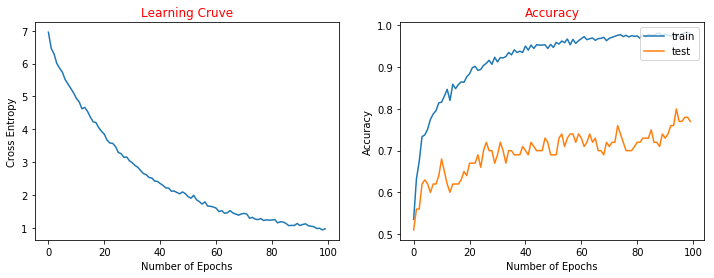

In [20]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 4)
ax[0].set_title('Learning Cruve', color='r')
ax[0].set_xlabel('Number of Epochs')
ax[0].set_ylabel('Cross Entropy')
ax[0].plot(history_loss)

ax[1].set_title('Accuracy', color='r')
ax[1].set_xlabel('Number of Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].plot(history_train_acc, label = 'train')
ax[1].plot(history_test_acc, label = 'test')
plt.legend(loc=1)